In [1]:
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [3]:
import torch.optim as optim
from torch.utils import data

## Model - 2d binary

In [4]:
## Bilinear interpolation plot for every combination of binary I/O

In [23]:
xs = [
    [0,0],
    [0,1],
    [1,0],
    [1,1],
]
xs = torch.Tensor(xs)
xs

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])

In [67]:
ys_ = []
for i in range(16):
    binval = str(bin(i))[2:]
    binval = "0000"[:4-len(binval)]+binval
    ys = [int(b) for b in binval]
    ys_.append(ys)
    
ys_ = torch.Tensor(ys_)
ys_

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [62]:
num_points = 100
X1 = np.linspace(-0.2, 1.2, num_points)
X2 = np.linspace(-0.2, 1.2, num_points)
X1, X2 = np.meshgrid(X1, X2)
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xgrid = torch.Tensor(np.c_[x1, x2])
xgrid.shape

torch.Size([10000, 2])

In [74]:
a00_ = ys_[:,0]
a01_ = ys_[:,1]-ys_[:,0]
a10_ = ys_[:,2]-ys_[:,0]
a11_ = ys_[:,3]-ys_[:,2]-ys_[:,1]+ys_[:,0]

In [86]:
i = 6 ## hard selection ; soft selection for training
ys = ys_[i]
a00 = a00_[i]
a01 = a01_[i]
a10 = a10_[i]
a11 = a11_[i]
ys

tensor([0., 1., 1., 0.])

In [87]:
y = a00 + a10*xgrid[:,0] + a01*xgrid[:,1] + a11*xgrid[:,0]*xgrid[:,1]

<IPython.core.display.Javascript object>


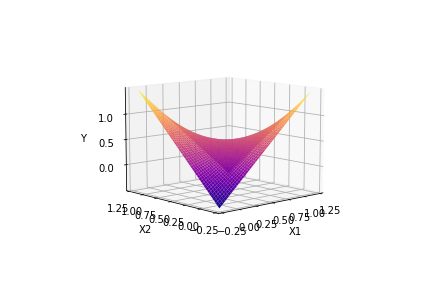

/tmp/ipykernel_295074/158416724.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [88]:
%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, y.cpu().numpy().reshape(X1.shape), cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [ ]:
## brute force find the closest binary mixing circuit.

In [89]:
ystr = []
for i in range(16):
    binval = str(bin(i))[2:]
    binval = "0000"[:4-len(binval)]+binval
    ystr.append(binval)
ystr    

['0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '1000',
 '1001',
 '1010',
 '1011',
 '1100',
 '1101',
 '1110',
 '1111']

In [116]:
xstr = {'00':0, '01':1, '10':2, '11':3}
xstr

{'00': 0, '01': 1, '10': 2, '11': 3}

In [117]:
def get_binary_circuit(x:str, index):
    i = xstr[x]
    y = ystr[index][i]
    return y

In [118]:
get_binary_circuit('00', 3)

'0'

In [119]:
list(xstr.keys())[0]

'00'

In [137]:
def get_binary_circuit_4D(x:str, y:str):
    config_list = []
    for a0 in range(1, 16):
        for a1 in tqdm(range(1, 16)):
            for a2 in range(1, 16):
                for a3 in range(1, 16):
                    for b0 in range(1, 16):
                        for b1 in range(1, 16):
                            for b2 in range(1, 16):
                                for b3 in range(1, 16):
                                    x0, x1 = x[0:2], x[2:4]
                                    z0 = get_binary_circuit(x0, a0)
                                    z1 = get_binary_circuit(x0, a1)
                                    z2 = get_binary_circuit(x1, a2)
                                    z3 = get_binary_circuit(x1, a3)
                                    
                                    z02, z13 = z0+z2, z1+z3
                                    y0 = get_binary_circuit(z02, b0)
                                    y1 = get_binary_circuit(z02, b1)
                                    y2 = get_binary_circuit(z13, b2)
                                    y3 = get_binary_circuit(z13, b3)
                                    
                                    yout = y0+y1+y2+y3
                                    
                                    correct = sum([int(y_ == t_) for y_, t_ in zip(yout, y)])
                                    
                                    if correct == 4:
                                        config_list += [(a0, a1, a2, a3, b0, b1, b2, b3, correct)]
                                        print(config_list[-1])
                                    
#                                 break
#                             break
#                         break
#                     break
#                 break
#             break
#         break
    return config_list

In [138]:
get_binary_circuit_4D('0011', '0000')

  0%|                                                              | 0/15 [00:00<?, ?it/s]

(1, 1, 1, 1, 1, 1, 1, 1, 4)
(1, 1, 1, 1, 1, 1, 1, 2, 4)
(1, 1, 1, 1, 1, 1, 1, 3, 4)
(1, 1, 1, 1, 1, 1, 1, 8, 4)
(1, 1, 1, 1, 1, 1, 1, 9, 4)
(1, 1, 1, 1, 1, 1, 1, 10, 4)
(1, 1, 1, 1, 1, 1, 1, 11, 4)
(1, 1, 1, 1, 1, 1, 2, 1, 4)
(1, 1, 1, 1, 1, 1, 2, 2, 4)
(1, 1, 1, 1, 1, 1, 2, 3, 4)
(1, 1, 1, 1, 1, 1, 2, 8, 4)
(1, 1, 1, 1, 1, 1, 2, 9, 4)
(1, 1, 1, 1, 1, 1, 2, 10, 4)
(1, 1, 1, 1, 1, 1, 2, 11, 4)
(1, 1, 1, 1, 1, 1, 3, 1, 4)
(1, 1, 1, 1, 1, 1, 3, 2, 4)
(1, 1, 1, 1, 1, 1, 3, 3, 4)
(1, 1, 1, 1, 1, 1, 3, 8, 4)
(1, 1, 1, 1, 1, 1, 3, 9, 4)
(1, 1, 1, 1, 1, 1, 3, 10, 4)
(1, 1, 1, 1, 1, 1, 3, 11, 4)
(1, 1, 1, 1, 1, 1, 8, 1, 4)
(1, 1, 1, 1, 1, 1, 8, 2, 4)
(1, 1, 1, 1, 1, 1, 8, 3, 4)
(1, 1, 1, 1, 1, 1, 8, 8, 4)
(1, 1, 1, 1, 1, 1, 8, 9, 4)
(1, 1, 1, 1, 1, 1, 8, 10, 4)
(1, 1, 1, 1, 1, 1, 8, 11, 4)
(1, 1, 1, 1, 1, 1, 9, 1, 4)
(1, 1, 1, 1, 1, 1, 9, 2, 4)
(1, 1, 1, 1, 1, 1, 9, 3, 4)
(1, 1, 1, 1, 1, 1, 9, 8, 4)
(1, 1, 1, 1, 1, 1, 9, 9, 4)
(1, 1, 1, 1, 1, 1, 9, 10, 4)
(1, 1, 1, 1, 1, 1, 9, 11, 4)
(1, 1, 1, 

(1, 1, 1, 3, 9, 2, 10, 2, 4)
(1, 1, 1, 3, 9, 2, 10, 3, 4)
(1, 1, 1, 3, 9, 2, 10, 8, 4)
(1, 1, 1, 3, 9, 2, 10, 9, 4)
(1, 1, 1, 3, 9, 2, 10, 10, 4)
(1, 1, 1, 3, 9, 2, 10, 11, 4)
(1, 1, 1, 3, 9, 2, 11, 1, 4)
(1, 1, 1, 3, 9, 2, 11, 2, 4)
(1, 1, 1, 3, 9, 2, 11, 3, 4)
(1, 1, 1, 3, 9, 2, 11, 8, 4)
(1, 1, 1, 3, 9, 2, 11, 9, 4)
(1, 1, 1, 3, 9, 2, 11, 10, 4)
(1, 1, 1, 3, 9, 2, 11, 11, 4)
(1, 1, 1, 3, 9, 3, 1, 1, 4)
(1, 1, 1, 3, 9, 3, 1, 2, 4)
(1, 1, 1, 3, 9, 3, 1, 3, 4)
(1, 1, 1, 3, 9, 3, 1, 8, 4)
(1, 1, 1, 3, 9, 3, 1, 9, 4)
(1, 1, 1, 3, 9, 3, 1, 10, 4)
(1, 1, 1, 3, 9, 3, 1, 11, 4)
(1, 1, 1, 3, 9, 3, 2, 1, 4)
(1, 1, 1, 3, 9, 3, 2, 2, 4)
(1, 1, 1, 3, 9, 3, 2, 3, 4)
(1, 1, 1, 3, 9, 3, 2, 8, 4)
(1, 1, 1, 3, 9, 3, 2, 9, 4)
(1, 1, 1, 3, 9, 3, 2, 10, 4)
(1, 1, 1, 3, 9, 3, 2, 11, 4)
(1, 1, 1, 3, 9, 3, 3, 1, 4)
(1, 1, 1, 3, 9, 3, 3, 2, 4)
(1, 1, 1, 3, 9, 3, 3, 3, 4)
(1, 1, 1, 3, 9, 3, 3, 8, 4)
(1, 1, 1, 3, 9, 3, 3, 9, 4)
(1, 1, 1, 3, 9, 3, 3, 10, 4)
(1, 1, 1, 3, 9, 3, 3, 11, 4)
(1, 1, 1, 3, 9, 3, 8, 1, 

(1, 1, 1, 6, 1, 8, 1, 1, 4)
(1, 1, 1, 6, 1, 8, 1, 2, 4)
(1, 1, 1, 6, 1, 8, 1, 3, 4)
(1, 1, 1, 6, 1, 8, 1, 4, 4)
(1, 1, 1, 6, 1, 8, 1, 5, 4)
(1, 1, 1, 6, 1, 8, 1, 6, 4)
(1, 1, 1, 6, 1, 8, 1, 7, 4)
(1, 1, 1, 6, 1, 8, 2, 1, 4)
(1, 1, 1, 6, 1, 8, 2, 2, 4)
(1, 1, 1, 6, 1, 8, 2, 3, 4)
(1, 1, 1, 6, 1, 8, 2, 4, 4)
(1, 1, 1, 6, 1, 8, 2, 5, 4)
(1, 1, 1, 6, 1, 8, 2, 6, 4)
(1, 1, 1, 6, 1, 8, 2, 7, 4)
(1, 1, 1, 6, 1, 8, 3, 1, 4)
(1, 1, 1, 6, 1, 8, 3, 2, 4)
(1, 1, 1, 6, 1, 8, 3, 3, 4)
(1, 1, 1, 6, 1, 8, 3, 4, 4)
(1, 1, 1, 6, 1, 8, 3, 5, 4)
(1, 1, 1, 6, 1, 8, 3, 6, 4)
(1, 1, 1, 6, 1, 8, 3, 7, 4)
(1, 1, 1, 6, 1, 8, 4, 1, 4)
(1, 1, 1, 6, 1, 8, 4, 2, 4)
(1, 1, 1, 6, 1, 8, 4, 3, 4)
(1, 1, 1, 6, 1, 8, 4, 4, 4)
(1, 1, 1, 6, 1, 8, 4, 5, 4)
(1, 1, 1, 6, 1, 8, 4, 6, 4)
(1, 1, 1, 6, 1, 8, 4, 7, 4)
(1, 1, 1, 6, 1, 8, 5, 1, 4)
(1, 1, 1, 6, 1, 8, 5, 2, 4)
(1, 1, 1, 6, 1, 8, 5, 3, 4)
(1, 1, 1, 6, 1, 8, 5, 4, 4)
(1, 1, 1, 6, 1, 8, 5, 5, 4)
(1, 1, 1, 6, 1, 8, 5, 6, 4)
(1, 1, 1, 6, 1, 8, 5, 7, 4)
(1, 1, 1, 6, 1, 8, 6

(1, 1, 1, 8, 8, 8, 1, 1, 4)
(1, 1, 1, 8, 8, 8, 1, 2, 4)
(1, 1, 1, 8, 8, 8, 1, 3, 4)
(1, 1, 1, 8, 8, 8, 1, 4, 4)
(1, 1, 1, 8, 8, 8, 1, 5, 4)
(1, 1, 1, 8, 8, 8, 1, 6, 4)
(1, 1, 1, 8, 8, 8, 1, 7, 4)
(1, 1, 1, 8, 8, 8, 2, 1, 4)
(1, 1, 1, 8, 8, 8, 2, 2, 4)
(1, 1, 1, 8, 8, 8, 2, 3, 4)
(1, 1, 1, 8, 8, 8, 2, 4, 4)
(1, 1, 1, 8, 8, 8, 2, 5, 4)
(1, 1, 1, 8, 8, 8, 2, 6, 4)
(1, 1, 1, 8, 8, 8, 2, 7, 4)
(1, 1, 1, 8, 8, 8, 3, 1, 4)
(1, 1, 1, 8, 8, 8, 3, 2, 4)
(1, 1, 1, 8, 8, 8, 3, 3, 4)
(1, 1, 1, 8, 8, 8, 3, 4, 4)
(1, 1, 1, 8, 8, 8, 3, 5, 4)
(1, 1, 1, 8, 8, 8, 3, 6, 4)
(1, 1, 1, 8, 8, 8, 3, 7, 4)
(1, 1, 1, 8, 8, 8, 4, 1, 4)
(1, 1, 1, 8, 8, 8, 4, 2, 4)
(1, 1, 1, 8, 8, 8, 4, 3, 4)
(1, 1, 1, 8, 8, 8, 4, 4, 4)
(1, 1, 1, 8, 8, 8, 4, 5, 4)
(1, 1, 1, 8, 8, 8, 4, 6, 4)
(1, 1, 1, 8, 8, 8, 4, 7, 4)
(1, 1, 1, 8, 8, 8, 5, 1, 4)
(1, 1, 1, 8, 8, 8, 5, 2, 4)
(1, 1, 1, 8, 8, 8, 5, 3, 4)
(1, 1, 1, 8, 8, 8, 5, 4, 4)
(1, 1, 1, 8, 8, 8, 5, 5, 4)
(1, 1, 1, 8, 8, 8, 5, 6, 4)
(1, 1, 1, 8, 8, 8, 5, 7, 4)
(1, 1, 1, 8, 8, 8, 6

(1, 1, 1, 11, 1, 1, 1, 1, 4)
(1, 1, 1, 11, 1, 1, 1, 2, 4)
(1, 1, 1, 11, 1, 1, 1, 3, 4)
(1, 1, 1, 11, 1, 1, 1, 8, 4)
(1, 1, 1, 11, 1, 1, 1, 9, 4)
(1, 1, 1, 11, 1, 1, 1, 10, 4)
(1, 1, 1, 11, 1, 1, 1, 11, 4)
(1, 1, 1, 11, 1, 1, 2, 1, 4)
(1, 1, 1, 11, 1, 1, 2, 2, 4)
(1, 1, 1, 11, 1, 1, 2, 3, 4)
(1, 1, 1, 11, 1, 1, 2, 8, 4)
(1, 1, 1, 11, 1, 1, 2, 9, 4)
(1, 1, 1, 11, 1, 1, 2, 10, 4)
(1, 1, 1, 11, 1, 1, 2, 11, 4)
(1, 1, 1, 11, 1, 1, 3, 1, 4)
(1, 1, 1, 11, 1, 1, 3, 2, 4)
(1, 1, 1, 11, 1, 1, 3, 3, 4)
(1, 1, 1, 11, 1, 1, 3, 8, 4)
(1, 1, 1, 11, 1, 1, 3, 9, 4)
(1, 1, 1, 11, 1, 1, 3, 10, 4)
(1, 1, 1, 11, 1, 1, 3, 11, 4)
(1, 1, 1, 11, 1, 1, 8, 1, 4)
(1, 1, 1, 11, 1, 1, 8, 2, 4)
(1, 1, 1, 11, 1, 1, 8, 3, 4)
(1, 1, 1, 11, 1, 1, 8, 8, 4)
(1, 1, 1, 11, 1, 1, 8, 9, 4)
(1, 1, 1, 11, 1, 1, 8, 10, 4)
(1, 1, 1, 11, 1, 1, 8, 11, 4)
(1, 1, 1, 11, 1, 1, 9, 1, 4)
(1, 1, 1, 11, 1, 1, 9, 2, 4)
(1, 1, 1, 11, 1, 1, 9, 3, 4)
(1, 1, 1, 11, 1, 1, 9, 8, 4)
(1, 1, 1, 11, 1, 1, 9, 9, 4)
(1, 1, 1, 11, 1, 1, 9, 10, 4)
(1, 1

(1, 1, 1, 13, 8, 1, 1, 1, 4)
(1, 1, 1, 13, 8, 1, 1, 2, 4)
(1, 1, 1, 13, 8, 1, 1, 3, 4)
(1, 1, 1, 13, 8, 1, 1, 8, 4)
(1, 1, 1, 13, 8, 1, 1, 9, 4)
(1, 1, 1, 13, 8, 1, 1, 10, 4)
(1, 1, 1, 13, 8, 1, 1, 11, 4)
(1, 1, 1, 13, 8, 1, 2, 1, 4)
(1, 1, 1, 13, 8, 1, 2, 2, 4)
(1, 1, 1, 13, 8, 1, 2, 3, 4)
(1, 1, 1, 13, 8, 1, 2, 8, 4)
(1, 1, 1, 13, 8, 1, 2, 9, 4)
(1, 1, 1, 13, 8, 1, 2, 10, 4)
(1, 1, 1, 13, 8, 1, 2, 11, 4)
(1, 1, 1, 13, 8, 1, 3, 1, 4)
(1, 1, 1, 13, 8, 1, 3, 2, 4)
(1, 1, 1, 13, 8, 1, 3, 3, 4)
(1, 1, 1, 13, 8, 1, 3, 8, 4)
(1, 1, 1, 13, 8, 1, 3, 9, 4)
(1, 1, 1, 13, 8, 1, 3, 10, 4)
(1, 1, 1, 13, 8, 1, 3, 11, 4)
(1, 1, 1, 13, 8, 1, 8, 1, 4)
(1, 1, 1, 13, 8, 1, 8, 2, 4)
(1, 1, 1, 13, 8, 1, 8, 3, 4)
(1, 1, 1, 13, 8, 1, 8, 8, 4)
(1, 1, 1, 13, 8, 1, 8, 9, 4)
(1, 1, 1, 13, 8, 1, 8, 10, 4)
(1, 1, 1, 13, 8, 1, 8, 11, 4)
(1, 1, 1, 13, 8, 1, 9, 1, 4)
(1, 1, 1, 13, 8, 1, 9, 2, 4)
(1, 1, 1, 13, 8, 1, 9, 3, 4)
(1, 1, 1, 13, 8, 1, 9, 8, 4)
(1, 1, 1, 13, 8, 1, 9, 9, 4)
(1, 1, 1, 13, 8, 1, 9, 10, 4)
(1, 1

(1, 1, 2, 1, 1, 1, 1, 1, 4)
(1, 1, 2, 1, 1, 1, 1, 2, 4)
(1, 1, 2, 1, 1, 1, 1, 3, 4)
(1, 1, 2, 1, 1, 1, 1, 8, 4)
(1, 1, 2, 1, 1, 1, 1, 9, 4)
(1, 1, 2, 1, 1, 1, 1, 10, 4)
(1, 1, 2, 1, 1, 1, 1, 11, 4)
(1, 1, 2, 1, 1, 1, 2, 1, 4)
(1, 1, 2, 1, 1, 1, 2, 2, 4)
(1, 1, 2, 1, 1, 1, 2, 3, 4)
(1, 1, 2, 1, 1, 1, 2, 8, 4)
(1, 1, 2, 1, 1, 1, 2, 9, 4)
(1, 1, 2, 1, 1, 1, 2, 10, 4)
(1, 1, 2, 1, 1, 1, 2, 11, 4)
(1, 1, 2, 1, 1, 1, 3, 1, 4)
(1, 1, 2, 1, 1, 1, 3, 2, 4)
(1, 1, 2, 1, 1, 1, 3, 3, 4)
(1, 1, 2, 1, 1, 1, 3, 8, 4)
(1, 1, 2, 1, 1, 1, 3, 9, 4)
(1, 1, 2, 1, 1, 1, 3, 10, 4)
(1, 1, 2, 1, 1, 1, 3, 11, 4)
(1, 1, 2, 1, 1, 1, 8, 1, 4)
(1, 1, 2, 1, 1, 1, 8, 2, 4)
(1, 1, 2, 1, 1, 1, 8, 3, 4)
(1, 1, 2, 1, 1, 1, 8, 8, 4)
(1, 1, 2, 1, 1, 1, 8, 9, 4)
(1, 1, 2, 1, 1, 1, 8, 10, 4)
(1, 1, 2, 1, 1, 1, 8, 11, 4)
(1, 1, 2, 1, 1, 1, 9, 1, 4)
(1, 1, 2, 1, 1, 1, 9, 2, 4)
(1, 1, 2, 1, 1, 1, 9, 3, 4)
(1, 1, 2, 1, 1, 1, 9, 8, 4)
(1, 1, 2, 1, 1, 1, 9, 9, 4)
(1, 1, 2, 1, 1, 1, 9, 10, 4)
(1, 1, 2, 1, 1, 1, 9, 11, 4)
(1, 1, 2, 

(1, 1, 2, 4, 1, 1, 1, 1, 4)
(1, 1, 2, 4, 1, 1, 1, 2, 4)
(1, 1, 2, 4, 1, 1, 1, 3, 4)
(1, 1, 2, 4, 1, 1, 1, 4, 4)
(1, 1, 2, 4, 1, 1, 1, 5, 4)
(1, 1, 2, 4, 1, 1, 1, 6, 4)
(1, 1, 2, 4, 1, 1, 1, 7, 4)
(1, 1, 2, 4, 1, 1, 2, 1, 4)
(1, 1, 2, 4, 1, 1, 2, 2, 4)
(1, 1, 2, 4, 1, 1, 2, 3, 4)
(1, 1, 2, 4, 1, 1, 2, 4, 4)
(1, 1, 2, 4, 1, 1, 2, 5, 4)
(1, 1, 2, 4, 1, 1, 2, 6, 4)
(1, 1, 2, 4, 1, 1, 2, 7, 4)
(1, 1, 2, 4, 1, 1, 3, 1, 4)
(1, 1, 2, 4, 1, 1, 3, 2, 4)
(1, 1, 2, 4, 1, 1, 3, 3, 4)
(1, 1, 2, 4, 1, 1, 3, 4, 4)
(1, 1, 2, 4, 1, 1, 3, 5, 4)
(1, 1, 2, 4, 1, 1, 3, 6, 4)
(1, 1, 2, 4, 1, 1, 3, 7, 4)
(1, 1, 2, 4, 1, 1, 4, 1, 4)
(1, 1, 2, 4, 1, 1, 4, 2, 4)
(1, 1, 2, 4, 1, 1, 4, 3, 4)
(1, 1, 2, 4, 1, 1, 4, 4, 4)
(1, 1, 2, 4, 1, 1, 4, 5, 4)
(1, 1, 2, 4, 1, 1, 4, 6, 4)
(1, 1, 2, 4, 1, 1, 4, 7, 4)
(1, 1, 2, 4, 1, 1, 5, 1, 4)
(1, 1, 2, 4, 1, 1, 5, 2, 4)
(1, 1, 2, 4, 1, 1, 5, 3, 4)
(1, 1, 2, 4, 1, 1, 5, 4, 4)
(1, 1, 2, 4, 1, 1, 5, 5, 4)
(1, 1, 2, 4, 1, 1, 5, 6, 4)
(1, 1, 2, 4, 1, 1, 5, 7, 4)
(1, 1, 2, 4, 1, 1, 6

(1, 1, 2, 7, 1, 1, 1, 1, 4)
(1, 1, 2, 7, 1, 1, 1, 2, 4)
(1, 1, 2, 7, 1, 1, 1, 3, 4)
(1, 1, 2, 7, 1, 1, 1, 8, 4)
(1, 1, 2, 7, 1, 1, 1, 9, 4)
(1, 1, 2, 7, 1, 1, 1, 10, 4)
(1, 1, 2, 7, 1, 1, 1, 11, 4)
(1, 1, 2, 7, 1, 1, 2, 1, 4)
(1, 1, 2, 7, 1, 1, 2, 2, 4)
(1, 1, 2, 7, 1, 1, 2, 3, 4)
(1, 1, 2, 7, 1, 1, 2, 8, 4)
(1, 1, 2, 7, 1, 1, 2, 9, 4)
(1, 1, 2, 7, 1, 1, 2, 10, 4)
(1, 1, 2, 7, 1, 1, 2, 11, 4)
(1, 1, 2, 7, 1, 1, 3, 1, 4)
(1, 1, 2, 7, 1, 1, 3, 2, 4)
(1, 1, 2, 7, 1, 1, 3, 3, 4)
(1, 1, 2, 7, 1, 1, 3, 8, 4)
(1, 1, 2, 7, 1, 1, 3, 9, 4)
(1, 1, 2, 7, 1, 1, 3, 10, 4)
(1, 1, 2, 7, 1, 1, 3, 11, 4)
(1, 1, 2, 7, 1, 1, 8, 1, 4)
(1, 1, 2, 7, 1, 1, 8, 2, 4)
(1, 1, 2, 7, 1, 1, 8, 3, 4)
(1, 1, 2, 7, 1, 1, 8, 8, 4)
(1, 1, 2, 7, 1, 1, 8, 9, 4)
(1, 1, 2, 7, 1, 1, 8, 10, 4)
(1, 1, 2, 7, 1, 1, 8, 11, 4)
(1, 1, 2, 7, 1, 1, 9, 1, 4)
(1, 1, 2, 7, 1, 1, 9, 2, 4)
(1, 1, 2, 7, 1, 1, 9, 3, 4)
(1, 1, 2, 7, 1, 1, 9, 8, 4)
(1, 1, 2, 7, 1, 1, 9, 9, 4)
(1, 1, 2, 7, 1, 1, 9, 10, 4)
(1, 1, 2, 7, 1, 1, 9, 11, 4)
(1, 1, 2, 

(1, 1, 2, 10, 1, 1, 1, 1, 4)
(1, 1, 2, 10, 1, 1, 1, 2, 4)
(1, 1, 2, 10, 1, 1, 1, 3, 4)
(1, 1, 2, 10, 1, 1, 1, 4, 4)
(1, 1, 2, 10, 1, 1, 1, 5, 4)
(1, 1, 2, 10, 1, 1, 1, 6, 4)
(1, 1, 2, 10, 1, 1, 1, 7, 4)
(1, 1, 2, 10, 1, 1, 2, 1, 4)
(1, 1, 2, 10, 1, 1, 2, 2, 4)
(1, 1, 2, 10, 1, 1, 2, 3, 4)
(1, 1, 2, 10, 1, 1, 2, 4, 4)
(1, 1, 2, 10, 1, 1, 2, 5, 4)
(1, 1, 2, 10, 1, 1, 2, 6, 4)
(1, 1, 2, 10, 1, 1, 2, 7, 4)
(1, 1, 2, 10, 1, 1, 3, 1, 4)
(1, 1, 2, 10, 1, 1, 3, 2, 4)
(1, 1, 2, 10, 1, 1, 3, 3, 4)
(1, 1, 2, 10, 1, 1, 3, 4, 4)
(1, 1, 2, 10, 1, 1, 3, 5, 4)
(1, 1, 2, 10, 1, 1, 3, 6, 4)
(1, 1, 2, 10, 1, 1, 3, 7, 4)
(1, 1, 2, 10, 1, 1, 4, 1, 4)
(1, 1, 2, 10, 1, 1, 4, 2, 4)
(1, 1, 2, 10, 1, 1, 4, 3, 4)
(1, 1, 2, 10, 1, 1, 4, 4, 4)
(1, 1, 2, 10, 1, 1, 4, 5, 4)
(1, 1, 2, 10, 1, 1, 4, 6, 4)
(1, 1, 2, 10, 1, 1, 4, 7, 4)
(1, 1, 2, 10, 1, 1, 5, 1, 4)
(1, 1, 2, 10, 1, 1, 5, 2, 4)
(1, 1, 2, 10, 1, 1, 5, 3, 4)
(1, 1, 2, 10, 1, 1, 5, 4, 4)
(1, 1, 2, 10, 1, 1, 5, 5, 4)
(1, 1, 2, 10, 1, 1, 5, 6, 4)
(1, 1, 2, 10, 

(1, 1, 2, 13, 1, 1, 1, 1, 4)
(1, 1, 2, 13, 1, 1, 1, 2, 4)
(1, 1, 2, 13, 1, 1, 1, 3, 4)
(1, 1, 2, 13, 1, 1, 1, 8, 4)
(1, 1, 2, 13, 1, 1, 1, 9, 4)
(1, 1, 2, 13, 1, 1, 1, 10, 4)
(1, 1, 2, 13, 1, 1, 1, 11, 4)
(1, 1, 2, 13, 1, 1, 2, 1, 4)
(1, 1, 2, 13, 1, 1, 2, 2, 4)
(1, 1, 2, 13, 1, 1, 2, 3, 4)
(1, 1, 2, 13, 1, 1, 2, 8, 4)
(1, 1, 2, 13, 1, 1, 2, 9, 4)
(1, 1, 2, 13, 1, 1, 2, 10, 4)
(1, 1, 2, 13, 1, 1, 2, 11, 4)
(1, 1, 2, 13, 1, 1, 3, 1, 4)
(1, 1, 2, 13, 1, 1, 3, 2, 4)
(1, 1, 2, 13, 1, 1, 3, 3, 4)
(1, 1, 2, 13, 1, 1, 3, 8, 4)
(1, 1, 2, 13, 1, 1, 3, 9, 4)
(1, 1, 2, 13, 1, 1, 3, 10, 4)
(1, 1, 2, 13, 1, 1, 3, 11, 4)
(1, 1, 2, 13, 1, 1, 8, 1, 4)
(1, 1, 2, 13, 1, 1, 8, 2, 4)
(1, 1, 2, 13, 1, 1, 8, 3, 4)
(1, 1, 2, 13, 1, 1, 8, 8, 4)
(1, 1, 2, 13, 1, 1, 8, 9, 4)
(1, 1, 2, 13, 1, 1, 8, 10, 4)
(1, 1, 2, 13, 1, 1, 8, 11, 4)
(1, 1, 2, 13, 1, 1, 9, 1, 4)
(1, 1, 2, 13, 1, 1, 9, 2, 4)
(1, 1, 2, 13, 1, 1, 9, 3, 4)
(1, 1, 2, 13, 1, 1, 9, 8, 4)
(1, 1, 2, 13, 1, 1, 9, 9, 4)
(1, 1, 2, 13, 1, 1, 9, 10, 4)
(1, 1

(1, 1, 2, 15, 7, 4, 9, 1, 4)
(1, 1, 2, 15, 7, 4, 9, 2, 4)
(1, 1, 2, 15, 7, 4, 9, 3, 4)
(1, 1, 2, 15, 7, 4, 9, 8, 4)
(1, 1, 2, 15, 7, 4, 9, 9, 4)
(1, 1, 2, 15, 7, 4, 9, 10, 4)
(1, 1, 2, 15, 7, 4, 9, 11, 4)
(1, 1, 2, 15, 7, 4, 10, 1, 4)
(1, 1, 2, 15, 7, 4, 10, 2, 4)
(1, 1, 2, 15, 7, 4, 10, 3, 4)
(1, 1, 2, 15, 7, 4, 10, 8, 4)
(1, 1, 2, 15, 7, 4, 10, 9, 4)
(1, 1, 2, 15, 7, 4, 10, 10, 4)
(1, 1, 2, 15, 7, 4, 10, 11, 4)
(1, 1, 2, 15, 7, 4, 11, 1, 4)
(1, 1, 2, 15, 7, 4, 11, 2, 4)
(1, 1, 2, 15, 7, 4, 11, 3, 4)
(1, 1, 2, 15, 7, 4, 11, 8, 4)
(1, 1, 2, 15, 7, 4, 11, 9, 4)
(1, 1, 2, 15, 7, 4, 11, 10, 4)
(1, 1, 2, 15, 7, 4, 11, 11, 4)
(1, 1, 2, 15, 7, 5, 1, 1, 4)
(1, 1, 2, 15, 7, 5, 1, 2, 4)
(1, 1, 2, 15, 7, 5, 1, 3, 4)
(1, 1, 2, 15, 7, 5, 1, 8, 4)
(1, 1, 2, 15, 7, 5, 1, 9, 4)
(1, 1, 2, 15, 7, 5, 1, 10, 4)
(1, 1, 2, 15, 7, 5, 1, 11, 4)
(1, 1, 2, 15, 7, 5, 2, 1, 4)
(1, 1, 2, 15, 7, 5, 2, 2, 4)
(1, 1, 2, 15, 7, 5, 2, 3, 4)
(1, 1, 2, 15, 7, 5, 2, 8, 4)
(1, 1, 2, 15, 7, 5, 2, 9, 4)
(1, 1, 2, 15, 7, 5, 2

(1, 1, 3, 3, 1, 1, 1, 1, 4)
(1, 1, 3, 3, 1, 1, 1, 2, 4)
(1, 1, 3, 3, 1, 1, 1, 3, 4)
(1, 1, 3, 3, 1, 1, 1, 8, 4)
(1, 1, 3, 3, 1, 1, 1, 9, 4)
(1, 1, 3, 3, 1, 1, 1, 10, 4)
(1, 1, 3, 3, 1, 1, 1, 11, 4)
(1, 1, 3, 3, 1, 1, 2, 1, 4)
(1, 1, 3, 3, 1, 1, 2, 2, 4)
(1, 1, 3, 3, 1, 1, 2, 3, 4)
(1, 1, 3, 3, 1, 1, 2, 8, 4)
(1, 1, 3, 3, 1, 1, 2, 9, 4)
(1, 1, 3, 3, 1, 1, 2, 10, 4)
(1, 1, 3, 3, 1, 1, 2, 11, 4)
(1, 1, 3, 3, 1, 1, 3, 1, 4)
(1, 1, 3, 3, 1, 1, 3, 2, 4)
(1, 1, 3, 3, 1, 1, 3, 3, 4)
(1, 1, 3, 3, 1, 1, 3, 8, 4)
(1, 1, 3, 3, 1, 1, 3, 9, 4)
(1, 1, 3, 3, 1, 1, 3, 10, 4)
(1, 1, 3, 3, 1, 1, 3, 11, 4)
(1, 1, 3, 3, 1, 1, 8, 1, 4)
(1, 1, 3, 3, 1, 1, 8, 2, 4)
(1, 1, 3, 3, 1, 1, 8, 3, 4)
(1, 1, 3, 3, 1, 1, 8, 8, 4)
(1, 1, 3, 3, 1, 1, 8, 9, 4)
(1, 1, 3, 3, 1, 1, 8, 10, 4)
(1, 1, 3, 3, 1, 1, 8, 11, 4)
(1, 1, 3, 3, 1, 1, 9, 1, 4)
(1, 1, 3, 3, 1, 1, 9, 2, 4)
(1, 1, 3, 3, 1, 1, 9, 3, 4)
(1, 1, 3, 3, 1, 1, 9, 8, 4)
(1, 1, 3, 3, 1, 1, 9, 9, 4)
(1, 1, 3, 3, 1, 1, 9, 10, 4)
(1, 1, 3, 3, 1, 1, 9, 11, 4)
(1, 1, 3, 

(1, 1, 3, 6, 1, 1, 1, 1, 4)
(1, 1, 3, 6, 1, 1, 1, 2, 4)
(1, 1, 3, 6, 1, 1, 1, 3, 4)
(1, 1, 3, 6, 1, 1, 1, 4, 4)
(1, 1, 3, 6, 1, 1, 1, 5, 4)
(1, 1, 3, 6, 1, 1, 1, 6, 4)
(1, 1, 3, 6, 1, 1, 1, 7, 4)
(1, 1, 3, 6, 1, 1, 2, 1, 4)
(1, 1, 3, 6, 1, 1, 2, 2, 4)
(1, 1, 3, 6, 1, 1, 2, 3, 4)
(1, 1, 3, 6, 1, 1, 2, 4, 4)
(1, 1, 3, 6, 1, 1, 2, 5, 4)
(1, 1, 3, 6, 1, 1, 2, 6, 4)
(1, 1, 3, 6, 1, 1, 2, 7, 4)
(1, 1, 3, 6, 1, 1, 3, 1, 4)
(1, 1, 3, 6, 1, 1, 3, 2, 4)
(1, 1, 3, 6, 1, 1, 3, 3, 4)
(1, 1, 3, 6, 1, 1, 3, 4, 4)
(1, 1, 3, 6, 1, 1, 3, 5, 4)
(1, 1, 3, 6, 1, 1, 3, 6, 4)
(1, 1, 3, 6, 1, 1, 3, 7, 4)
(1, 1, 3, 6, 1, 1, 4, 1, 4)
(1, 1, 3, 6, 1, 1, 4, 2, 4)
(1, 1, 3, 6, 1, 1, 4, 3, 4)
(1, 1, 3, 6, 1, 1, 4, 4, 4)
(1, 1, 3, 6, 1, 1, 4, 5, 4)
(1, 1, 3, 6, 1, 1, 4, 6, 4)
(1, 1, 3, 6, 1, 1, 4, 7, 4)
(1, 1, 3, 6, 1, 1, 5, 1, 4)
(1, 1, 3, 6, 1, 1, 5, 2, 4)
(1, 1, 3, 6, 1, 1, 5, 3, 4)
(1, 1, 3, 6, 1, 1, 5, 4, 4)
(1, 1, 3, 6, 1, 1, 5, 5, 4)
(1, 1, 3, 6, 1, 1, 5, 6, 4)
(1, 1, 3, 6, 1, 1, 5, 7, 4)
(1, 1, 3, 6, 1, 1, 6

(1, 1, 3, 9, 1, 1, 1, 1, 4)
(1, 1, 3, 9, 1, 1, 1, 2, 4)
(1, 1, 3, 9, 1, 1, 1, 3, 4)
(1, 1, 3, 9, 1, 1, 1, 8, 4)
(1, 1, 3, 9, 1, 1, 1, 9, 4)
(1, 1, 3, 9, 1, 1, 1, 10, 4)
(1, 1, 3, 9, 1, 1, 1, 11, 4)
(1, 1, 3, 9, 1, 1, 2, 1, 4)
(1, 1, 3, 9, 1, 1, 2, 2, 4)
(1, 1, 3, 9, 1, 1, 2, 3, 4)
(1, 1, 3, 9, 1, 1, 2, 8, 4)
(1, 1, 3, 9, 1, 1, 2, 9, 4)
(1, 1, 3, 9, 1, 1, 2, 10, 4)
(1, 1, 3, 9, 1, 1, 2, 11, 4)
(1, 1, 3, 9, 1, 1, 3, 1, 4)
(1, 1, 3, 9, 1, 1, 3, 2, 4)
(1, 1, 3, 9, 1, 1, 3, 3, 4)
(1, 1, 3, 9, 1, 1, 3, 8, 4)
(1, 1, 3, 9, 1, 1, 3, 9, 4)
(1, 1, 3, 9, 1, 1, 3, 10, 4)
(1, 1, 3, 9, 1, 1, 3, 11, 4)
(1, 1, 3, 9, 1, 1, 8, 1, 4)
(1, 1, 3, 9, 1, 1, 8, 2, 4)
(1, 1, 3, 9, 1, 1, 8, 3, 4)
(1, 1, 3, 9, 1, 1, 8, 8, 4)
(1, 1, 3, 9, 1, 1, 8, 9, 4)
(1, 1, 3, 9, 1, 1, 8, 10, 4)
(1, 1, 3, 9, 1, 1, 8, 11, 4)
(1, 1, 3, 9, 1, 1, 9, 1, 4)
(1, 1, 3, 9, 1, 1, 9, 2, 4)
(1, 1, 3, 9, 1, 1, 9, 3, 4)
(1, 1, 3, 9, 1, 1, 9, 8, 4)
(1, 1, 3, 9, 1, 1, 9, 9, 4)
(1, 1, 3, 9, 1, 1, 9, 10, 4)
(1, 1, 3, 9, 1, 1, 9, 11, 4)
(1, 1, 3, 

(1, 1, 3, 12, 1, 1, 1, 1, 4)
(1, 1, 3, 12, 1, 1, 1, 2, 4)
(1, 1, 3, 12, 1, 1, 1, 3, 4)
(1, 1, 3, 12, 1, 1, 1, 4, 4)
(1, 1, 3, 12, 1, 1, 1, 5, 4)
(1, 1, 3, 12, 1, 1, 1, 6, 4)
(1, 1, 3, 12, 1, 1, 1, 7, 4)
(1, 1, 3, 12, 1, 1, 2, 1, 4)
(1, 1, 3, 12, 1, 1, 2, 2, 4)
(1, 1, 3, 12, 1, 1, 2, 3, 4)
(1, 1, 3, 12, 1, 1, 2, 4, 4)
(1, 1, 3, 12, 1, 1, 2, 5, 4)
(1, 1, 3, 12, 1, 1, 2, 6, 4)
(1, 1, 3, 12, 1, 1, 2, 7, 4)
(1, 1, 3, 12, 1, 1, 3, 1, 4)
(1, 1, 3, 12, 1, 1, 3, 2, 4)
(1, 1, 3, 12, 1, 1, 3, 3, 4)
(1, 1, 3, 12, 1, 1, 3, 4, 4)
(1, 1, 3, 12, 1, 1, 3, 5, 4)
(1, 1, 3, 12, 1, 1, 3, 6, 4)
(1, 1, 3, 12, 1, 1, 3, 7, 4)
(1, 1, 3, 12, 1, 1, 4, 1, 4)
(1, 1, 3, 12, 1, 1, 4, 2, 4)
(1, 1, 3, 12, 1, 1, 4, 3, 4)
(1, 1, 3, 12, 1, 1, 4, 4, 4)
(1, 1, 3, 12, 1, 1, 4, 5, 4)
(1, 1, 3, 12, 1, 1, 4, 6, 4)
(1, 1, 3, 12, 1, 1, 4, 7, 4)
(1, 1, 3, 12, 1, 1, 5, 1, 4)
(1, 1, 3, 12, 1, 1, 5, 2, 4)
(1, 1, 3, 12, 1, 1, 5, 3, 4)
(1, 1, 3, 12, 1, 1, 5, 4, 4)
(1, 1, 3, 12, 1, 1, 5, 5, 4)
(1, 1, 3, 12, 1, 1, 5, 6, 4)
(1, 1, 3, 12, 

(1, 1, 3, 15, 1, 1, 1, 1, 4)
(1, 1, 3, 15, 1, 1, 1, 2, 4)
(1, 1, 3, 15, 1, 1, 1, 3, 4)
(1, 1, 3, 15, 1, 1, 1, 8, 4)
(1, 1, 3, 15, 1, 1, 1, 9, 4)
(1, 1, 3, 15, 1, 1, 1, 10, 4)
(1, 1, 3, 15, 1, 1, 1, 11, 4)
(1, 1, 3, 15, 1, 1, 2, 1, 4)
(1, 1, 3, 15, 1, 1, 2, 2, 4)
(1, 1, 3, 15, 1, 1, 2, 3, 4)
(1, 1, 3, 15, 1, 1, 2, 8, 4)
(1, 1, 3, 15, 1, 1, 2, 9, 4)
(1, 1, 3, 15, 1, 1, 2, 10, 4)
(1, 1, 3, 15, 1, 1, 2, 11, 4)
(1, 1, 3, 15, 1, 1, 3, 1, 4)
(1, 1, 3, 15, 1, 1, 3, 2, 4)
(1, 1, 3, 15, 1, 1, 3, 3, 4)
(1, 1, 3, 15, 1, 1, 3, 8, 4)
(1, 1, 3, 15, 1, 1, 3, 9, 4)
(1, 1, 3, 15, 1, 1, 3, 10, 4)
(1, 1, 3, 15, 1, 1, 3, 11, 4)
(1, 1, 3, 15, 1, 1, 8, 1, 4)
(1, 1, 3, 15, 1, 1, 8, 2, 4)
(1, 1, 3, 15, 1, 1, 8, 3, 4)
(1, 1, 3, 15, 1, 1, 8, 8, 4)
(1, 1, 3, 15, 1, 1, 8, 9, 4)
(1, 1, 3, 15, 1, 1, 8, 10, 4)
(1, 1, 3, 15, 1, 1, 8, 11, 4)
(1, 1, 3, 15, 1, 1, 9, 1, 4)
(1, 1, 3, 15, 1, 1, 9, 2, 4)
(1, 1, 3, 15, 1, 1, 9, 3, 4)
(1, 1, 3, 15, 1, 1, 9, 8, 4)
(1, 1, 3, 15, 1, 1, 9, 9, 4)
(1, 1, 3, 15, 1, 1, 9, 10, 4)
(1, 1

(1, 1, 4, 3, 1, 1, 1, 1, 4)
(1, 1, 4, 3, 1, 1, 1, 2, 4)
(1, 1, 4, 3, 1, 1, 1, 3, 4)
(1, 1, 4, 3, 1, 1, 1, 8, 4)
(1, 1, 4, 3, 1, 1, 1, 9, 4)
(1, 1, 4, 3, 1, 1, 1, 10, 4)
(1, 1, 4, 3, 1, 1, 1, 11, 4)
(1, 1, 4, 3, 1, 1, 2, 1, 4)
(1, 1, 4, 3, 1, 1, 2, 2, 4)
(1, 1, 4, 3, 1, 1, 2, 3, 4)
(1, 1, 4, 3, 1, 1, 2, 8, 4)
(1, 1, 4, 3, 1, 1, 2, 9, 4)
(1, 1, 4, 3, 1, 1, 2, 10, 4)
(1, 1, 4, 3, 1, 1, 2, 11, 4)
(1, 1, 4, 3, 1, 1, 3, 1, 4)
(1, 1, 4, 3, 1, 1, 3, 2, 4)
(1, 1, 4, 3, 1, 1, 3, 3, 4)
(1, 1, 4, 3, 1, 1, 3, 8, 4)
(1, 1, 4, 3, 1, 1, 3, 9, 4)
(1, 1, 4, 3, 1, 1, 3, 10, 4)
(1, 1, 4, 3, 1, 1, 3, 11, 4)
(1, 1, 4, 3, 1, 1, 8, 1, 4)
(1, 1, 4, 3, 1, 1, 8, 2, 4)
(1, 1, 4, 3, 1, 1, 8, 3, 4)
(1, 1, 4, 3, 1, 1, 8, 8, 4)
(1, 1, 4, 3, 1, 1, 8, 9, 4)
(1, 1, 4, 3, 1, 1, 8, 10, 4)
(1, 1, 4, 3, 1, 1, 8, 11, 4)
(1, 1, 4, 3, 1, 1, 9, 1, 4)
(1, 1, 4, 3, 1, 1, 9, 2, 4)
(1, 1, 4, 3, 1, 1, 9, 3, 4)
(1, 1, 4, 3, 1, 1, 9, 8, 4)
(1, 1, 4, 3, 1, 1, 9, 9, 4)
(1, 1, 4, 3, 1, 1, 9, 10, 4)
(1, 1, 4, 3, 1, 1, 9, 11, 4)
(1, 1, 4, 

(1, 1, 4, 5, 6, 6, 10, 8, 4)
(1, 1, 4, 5, 6, 6, 10, 9, 4)
(1, 1, 4, 5, 6, 6, 10, 10, 4)
(1, 1, 4, 5, 6, 6, 10, 11, 4)
(1, 1, 4, 5, 6, 6, 11, 1, 4)
(1, 1, 4, 5, 6, 6, 11, 2, 4)
(1, 1, 4, 5, 6, 6, 11, 3, 4)
(1, 1, 4, 5, 6, 6, 11, 8, 4)
(1, 1, 4, 5, 6, 6, 11, 9, 4)
(1, 1, 4, 5, 6, 6, 11, 10, 4)
(1, 1, 4, 5, 6, 6, 11, 11, 4)
(1, 1, 4, 5, 6, 7, 1, 1, 4)
(1, 1, 4, 5, 6, 7, 1, 2, 4)
(1, 1, 4, 5, 6, 7, 1, 3, 4)
(1, 1, 4, 5, 6, 7, 1, 8, 4)
(1, 1, 4, 5, 6, 7, 1, 9, 4)
(1, 1, 4, 5, 6, 7, 1, 10, 4)
(1, 1, 4, 5, 6, 7, 1, 11, 4)
(1, 1, 4, 5, 6, 7, 2, 1, 4)
(1, 1, 4, 5, 6, 7, 2, 2, 4)
(1, 1, 4, 5, 6, 7, 2, 3, 4)
(1, 1, 4, 5, 6, 7, 2, 8, 4)
(1, 1, 4, 5, 6, 7, 2, 9, 4)
(1, 1, 4, 5, 6, 7, 2, 10, 4)
(1, 1, 4, 5, 6, 7, 2, 11, 4)
(1, 1, 4, 5, 6, 7, 3, 1, 4)
(1, 1, 4, 5, 6, 7, 3, 2, 4)
(1, 1, 4, 5, 6, 7, 3, 3, 4)
(1, 1, 4, 5, 6, 7, 3, 8, 4)
(1, 1, 4, 5, 6, 7, 3, 9, 4)
(1, 1, 4, 5, 6, 7, 3, 10, 4)
(1, 1, 4, 5, 6, 7, 3, 11, 4)
(1, 1, 4, 5, 6, 7, 8, 1, 4)
(1, 1, 4, 5, 6, 7, 8, 2, 4)
(1, 1, 4, 5, 6, 7, 8, 3, 4)

(1, 1, 4, 8, 1, 1, 1, 1, 4)
(1, 1, 4, 8, 1, 1, 1, 2, 4)
(1, 1, 4, 8, 1, 1, 1, 3, 4)
(1, 1, 4, 8, 1, 1, 1, 4, 4)
(1, 1, 4, 8, 1, 1, 1, 5, 4)
(1, 1, 4, 8, 1, 1, 1, 6, 4)
(1, 1, 4, 8, 1, 1, 1, 7, 4)
(1, 1, 4, 8, 1, 1, 2, 1, 4)
(1, 1, 4, 8, 1, 1, 2, 2, 4)
(1, 1, 4, 8, 1, 1, 2, 3, 4)
(1, 1, 4, 8, 1, 1, 2, 4, 4)
(1, 1, 4, 8, 1, 1, 2, 5, 4)
(1, 1, 4, 8, 1, 1, 2, 6, 4)
(1, 1, 4, 8, 1, 1, 2, 7, 4)
(1, 1, 4, 8, 1, 1, 3, 1, 4)
(1, 1, 4, 8, 1, 1, 3, 2, 4)
(1, 1, 4, 8, 1, 1, 3, 3, 4)
(1, 1, 4, 8, 1, 1, 3, 4, 4)
(1, 1, 4, 8, 1, 1, 3, 5, 4)
(1, 1, 4, 8, 1, 1, 3, 6, 4)
(1, 1, 4, 8, 1, 1, 3, 7, 4)
(1, 1, 4, 8, 1, 1, 4, 1, 4)
(1, 1, 4, 8, 1, 1, 4, 2, 4)
(1, 1, 4, 8, 1, 1, 4, 3, 4)
(1, 1, 4, 8, 1, 1, 4, 4, 4)
(1, 1, 4, 8, 1, 1, 4, 5, 4)
(1, 1, 4, 8, 1, 1, 4, 6, 4)
(1, 1, 4, 8, 1, 1, 4, 7, 4)
(1, 1, 4, 8, 1, 1, 5, 1, 4)
(1, 1, 4, 8, 1, 1, 5, 2, 4)
(1, 1, 4, 8, 1, 1, 5, 3, 4)
(1, 1, 4, 8, 1, 1, 5, 4, 4)
(1, 1, 4, 8, 1, 1, 5, 5, 4)
(1, 1, 4, 8, 1, 1, 5, 6, 4)
(1, 1, 4, 8, 1, 1, 5, 7, 4)
(1, 1, 4, 8, 1, 1, 6

(1, 1, 4, 10, 7, 5, 4, 1, 4)
(1, 1, 4, 10, 7, 5, 4, 2, 4)
(1, 1, 4, 10, 7, 5, 4, 3, 4)
(1, 1, 4, 10, 7, 5, 4, 4, 4)
(1, 1, 4, 10, 7, 5, 4, 5, 4)
(1, 1, 4, 10, 7, 5, 4, 6, 4)
(1, 1, 4, 10, 7, 5, 4, 7, 4)
(1, 1, 4, 10, 7, 5, 5, 1, 4)
(1, 1, 4, 10, 7, 5, 5, 2, 4)
(1, 1, 4, 10, 7, 5, 5, 3, 4)
(1, 1, 4, 10, 7, 5, 5, 4, 4)
(1, 1, 4, 10, 7, 5, 5, 5, 4)
(1, 1, 4, 10, 7, 5, 5, 6, 4)
(1, 1, 4, 10, 7, 5, 5, 7, 4)
(1, 1, 4, 10, 7, 5, 6, 1, 4)
(1, 1, 4, 10, 7, 5, 6, 2, 4)
(1, 1, 4, 10, 7, 5, 6, 3, 4)
(1, 1, 4, 10, 7, 5, 6, 4, 4)
(1, 1, 4, 10, 7, 5, 6, 5, 4)
(1, 1, 4, 10, 7, 5, 6, 6, 4)
(1, 1, 4, 10, 7, 5, 6, 7, 4)
(1, 1, 4, 10, 7, 5, 7, 1, 4)
(1, 1, 4, 10, 7, 5, 7, 2, 4)
(1, 1, 4, 10, 7, 5, 7, 3, 4)
(1, 1, 4, 10, 7, 5, 7, 4, 4)
(1, 1, 4, 10, 7, 5, 7, 5, 4)
(1, 1, 4, 10, 7, 5, 7, 6, 4)
(1, 1, 4, 10, 7, 5, 7, 7, 4)
(1, 1, 4, 10, 7, 6, 1, 1, 4)
(1, 1, 4, 10, 7, 6, 1, 2, 4)
(1, 1, 4, 10, 7, 6, 1, 3, 4)
(1, 1, 4, 10, 7, 6, 1, 4, 4)
(1, 1, 4, 10, 7, 6, 1, 5, 4)
(1, 1, 4, 10, 7, 6, 1, 6, 4)
(1, 1, 4, 10, 

(1, 1, 4, 13, 1, 1, 1, 1, 4)
(1, 1, 4, 13, 1, 1, 1, 2, 4)
(1, 1, 4, 13, 1, 1, 1, 3, 4)
(1, 1, 4, 13, 1, 1, 1, 8, 4)
(1, 1, 4, 13, 1, 1, 1, 9, 4)
(1, 1, 4, 13, 1, 1, 1, 10, 4)
(1, 1, 4, 13, 1, 1, 1, 11, 4)
(1, 1, 4, 13, 1, 1, 2, 1, 4)
(1, 1, 4, 13, 1, 1, 2, 2, 4)
(1, 1, 4, 13, 1, 1, 2, 3, 4)
(1, 1, 4, 13, 1, 1, 2, 8, 4)
(1, 1, 4, 13, 1, 1, 2, 9, 4)
(1, 1, 4, 13, 1, 1, 2, 10, 4)
(1, 1, 4, 13, 1, 1, 2, 11, 4)
(1, 1, 4, 13, 1, 1, 3, 1, 4)
(1, 1, 4, 13, 1, 1, 3, 2, 4)
(1, 1, 4, 13, 1, 1, 3, 3, 4)
(1, 1, 4, 13, 1, 1, 3, 8, 4)
(1, 1, 4, 13, 1, 1, 3, 9, 4)
(1, 1, 4, 13, 1, 1, 3, 10, 4)
(1, 1, 4, 13, 1, 1, 3, 11, 4)
(1, 1, 4, 13, 1, 1, 8, 1, 4)
(1, 1, 4, 13, 1, 1, 8, 2, 4)
(1, 1, 4, 13, 1, 1, 8, 3, 4)
(1, 1, 4, 13, 1, 1, 8, 8, 4)
(1, 1, 4, 13, 1, 1, 8, 9, 4)
(1, 1, 4, 13, 1, 1, 8, 10, 4)
(1, 1, 4, 13, 1, 1, 8, 11, 4)
(1, 1, 4, 13, 1, 1, 9, 1, 4)
(1, 1, 4, 13, 1, 1, 9, 2, 4)
(1, 1, 4, 13, 1, 1, 9, 3, 4)
(1, 1, 4, 13, 1, 1, 9, 8, 4)
(1, 1, 4, 13, 1, 1, 9, 9, 4)
(1, 1, 4, 13, 1, 1, 9, 10, 4)
(1, 1

(1, 1, 5, 1, 1, 1, 1, 1, 4)
(1, 1, 5, 1, 1, 1, 1, 2, 4)
(1, 1, 5, 1, 1, 1, 1, 3, 4)
(1, 1, 5, 1, 1, 1, 1, 8, 4)
(1, 1, 5, 1, 1, 1, 1, 9, 4)
(1, 1, 5, 1, 1, 1, 1, 10, 4)
(1, 1, 5, 1, 1, 1, 1, 11, 4)
(1, 1, 5, 1, 1, 1, 2, 1, 4)
(1, 1, 5, 1, 1, 1, 2, 2, 4)
(1, 1, 5, 1, 1, 1, 2, 3, 4)
(1, 1, 5, 1, 1, 1, 2, 8, 4)
(1, 1, 5, 1, 1, 1, 2, 9, 4)
(1, 1, 5, 1, 1, 1, 2, 10, 4)
(1, 1, 5, 1, 1, 1, 2, 11, 4)
(1, 1, 5, 1, 1, 1, 3, 1, 4)
(1, 1, 5, 1, 1, 1, 3, 2, 4)
(1, 1, 5, 1, 1, 1, 3, 3, 4)
(1, 1, 5, 1, 1, 1, 3, 8, 4)
(1, 1, 5, 1, 1, 1, 3, 9, 4)
(1, 1, 5, 1, 1, 1, 3, 10, 4)
(1, 1, 5, 1, 1, 1, 3, 11, 4)
(1, 1, 5, 1, 1, 1, 8, 1, 4)
(1, 1, 5, 1, 1, 1, 8, 2, 4)
(1, 1, 5, 1, 1, 1, 8, 3, 4)
(1, 1, 5, 1, 1, 1, 8, 8, 4)
(1, 1, 5, 1, 1, 1, 8, 9, 4)
(1, 1, 5, 1, 1, 1, 8, 10, 4)
(1, 1, 5, 1, 1, 1, 8, 11, 4)
(1, 1, 5, 1, 1, 1, 9, 1, 4)
(1, 1, 5, 1, 1, 1, 9, 2, 4)
(1, 1, 5, 1, 1, 1, 9, 3, 4)
(1, 1, 5, 1, 1, 1, 9, 8, 4)
(1, 1, 5, 1, 1, 1, 9, 9, 4)
(1, 1, 5, 1, 1, 1, 9, 10, 4)
(1, 1, 5, 1, 1, 1, 9, 11, 4)
(1, 1, 5, 

(1, 1, 5, 4, 1, 1, 1, 1, 4)
(1, 1, 5, 4, 1, 1, 1, 2, 4)
(1, 1, 5, 4, 1, 1, 1, 3, 4)
(1, 1, 5, 4, 1, 1, 1, 4, 4)
(1, 1, 5, 4, 1, 1, 1, 5, 4)
(1, 1, 5, 4, 1, 1, 1, 6, 4)
(1, 1, 5, 4, 1, 1, 1, 7, 4)
(1, 1, 5, 4, 1, 1, 2, 1, 4)
(1, 1, 5, 4, 1, 1, 2, 2, 4)
(1, 1, 5, 4, 1, 1, 2, 3, 4)
(1, 1, 5, 4, 1, 1, 2, 4, 4)
(1, 1, 5, 4, 1, 1, 2, 5, 4)
(1, 1, 5, 4, 1, 1, 2, 6, 4)
(1, 1, 5, 4, 1, 1, 2, 7, 4)
(1, 1, 5, 4, 1, 1, 3, 1, 4)
(1, 1, 5, 4, 1, 1, 3, 2, 4)
(1, 1, 5, 4, 1, 1, 3, 3, 4)
(1, 1, 5, 4, 1, 1, 3, 4, 4)
(1, 1, 5, 4, 1, 1, 3, 5, 4)
(1, 1, 5, 4, 1, 1, 3, 6, 4)
(1, 1, 5, 4, 1, 1, 3, 7, 4)
(1, 1, 5, 4, 1, 1, 4, 1, 4)
(1, 1, 5, 4, 1, 1, 4, 2, 4)
(1, 1, 5, 4, 1, 1, 4, 3, 4)
(1, 1, 5, 4, 1, 1, 4, 4, 4)
(1, 1, 5, 4, 1, 1, 4, 5, 4)
(1, 1, 5, 4, 1, 1, 4, 6, 4)
(1, 1, 5, 4, 1, 1, 4, 7, 4)
(1, 1, 5, 4, 1, 1, 5, 1, 4)
(1, 1, 5, 4, 1, 1, 5, 2, 4)
(1, 1, 5, 4, 1, 1, 5, 3, 4)
(1, 1, 5, 4, 1, 1, 5, 4, 4)
(1, 1, 5, 4, 1, 1, 5, 5, 4)
(1, 1, 5, 4, 1, 1, 5, 6, 4)
(1, 1, 5, 4, 1, 1, 5, 7, 4)
(1, 1, 5, 4, 1, 1, 6

(1, 1, 5, 7, 1, 1, 1, 1, 4)
(1, 1, 5, 7, 1, 1, 1, 2, 4)
(1, 1, 5, 7, 1, 1, 1, 3, 4)
(1, 1, 5, 7, 1, 1, 1, 8, 4)
(1, 1, 5, 7, 1, 1, 1, 9, 4)
(1, 1, 5, 7, 1, 1, 1, 10, 4)
(1, 1, 5, 7, 1, 1, 1, 11, 4)
(1, 1, 5, 7, 1, 1, 2, 1, 4)
(1, 1, 5, 7, 1, 1, 2, 2, 4)
(1, 1, 5, 7, 1, 1, 2, 3, 4)
(1, 1, 5, 7, 1, 1, 2, 8, 4)
(1, 1, 5, 7, 1, 1, 2, 9, 4)
(1, 1, 5, 7, 1, 1, 2, 10, 4)
(1, 1, 5, 7, 1, 1, 2, 11, 4)
(1, 1, 5, 7, 1, 1, 3, 1, 4)
(1, 1, 5, 7, 1, 1, 3, 2, 4)
(1, 1, 5, 7, 1, 1, 3, 3, 4)
(1, 1, 5, 7, 1, 1, 3, 8, 4)
(1, 1, 5, 7, 1, 1, 3, 9, 4)
(1, 1, 5, 7, 1, 1, 3, 10, 4)
(1, 1, 5, 7, 1, 1, 3, 11, 4)
(1, 1, 5, 7, 1, 1, 8, 1, 4)
(1, 1, 5, 7, 1, 1, 8, 2, 4)
(1, 1, 5, 7, 1, 1, 8, 3, 4)
(1, 1, 5, 7, 1, 1, 8, 8, 4)
(1, 1, 5, 7, 1, 1, 8, 9, 4)
(1, 1, 5, 7, 1, 1, 8, 10, 4)
(1, 1, 5, 7, 1, 1, 8, 11, 4)
(1, 1, 5, 7, 1, 1, 9, 1, 4)
(1, 1, 5, 7, 1, 1, 9, 2, 4)
(1, 1, 5, 7, 1, 1, 9, 3, 4)
(1, 1, 5, 7, 1, 1, 9, 8, 4)
(1, 1, 5, 7, 1, 1, 9, 9, 4)
(1, 1, 5, 7, 1, 1, 9, 10, 4)
(1, 1, 5, 7, 1, 1, 9, 11, 4)
(1, 1, 5, 

(1, 1, 5, 9, 10, 2, 10, 3, 4)
(1, 1, 5, 9, 10, 2, 10, 8, 4)
(1, 1, 5, 9, 10, 2, 10, 9, 4)
(1, 1, 5, 9, 10, 2, 10, 10, 4)
(1, 1, 5, 9, 10, 2, 10, 11, 4)
(1, 1, 5, 9, 10, 2, 11, 1, 4)
(1, 1, 5, 9, 10, 2, 11, 2, 4)
(1, 1, 5, 9, 10, 2, 11, 3, 4)
(1, 1, 5, 9, 10, 2, 11, 8, 4)
(1, 1, 5, 9, 10, 2, 11, 9, 4)
(1, 1, 5, 9, 10, 2, 11, 10, 4)
(1, 1, 5, 9, 10, 2, 11, 11, 4)
(1, 1, 5, 9, 10, 3, 1, 1, 4)
(1, 1, 5, 9, 10, 3, 1, 2, 4)
(1, 1, 5, 9, 10, 3, 1, 3, 4)
(1, 1, 5, 9, 10, 3, 1, 8, 4)
(1, 1, 5, 9, 10, 3, 1, 9, 4)
(1, 1, 5, 9, 10, 3, 1, 10, 4)
(1, 1, 5, 9, 10, 3, 1, 11, 4)
(1, 1, 5, 9, 10, 3, 2, 1, 4)
(1, 1, 5, 9, 10, 3, 2, 2, 4)
(1, 1, 5, 9, 10, 3, 2, 3, 4)
(1, 1, 5, 9, 10, 3, 2, 8, 4)
(1, 1, 5, 9, 10, 3, 2, 9, 4)
(1, 1, 5, 9, 10, 3, 2, 10, 4)
(1, 1, 5, 9, 10, 3, 2, 11, 4)
(1, 1, 5, 9, 10, 3, 3, 1, 4)
(1, 1, 5, 9, 10, 3, 3, 2, 4)
(1, 1, 5, 9, 10, 3, 3, 3, 4)
(1, 1, 5, 9, 10, 3, 3, 8, 4)
(1, 1, 5, 9, 10, 3, 3, 9, 4)
(1, 1, 5, 9, 10, 3, 3, 10, 4)
(1, 1, 5, 9, 10, 3, 3, 11, 4)
(1, 1, 5, 9, 10, 3, 8

(1, 1, 5, 12, 1, 3, 1, 1, 4)
(1, 1, 5, 12, 1, 3, 1, 2, 4)
(1, 1, 5, 12, 1, 3, 1, 3, 4)
(1, 1, 5, 12, 1, 3, 1, 4, 4)
(1, 1, 5, 12, 1, 3, 1, 5, 4)
(1, 1, 5, 12, 1, 3, 1, 6, 4)
(1, 1, 5, 12, 1, 3, 1, 7, 4)
(1, 1, 5, 12, 1, 3, 2, 1, 4)
(1, 1, 5, 12, 1, 3, 2, 2, 4)
(1, 1, 5, 12, 1, 3, 2, 3, 4)
(1, 1, 5, 12, 1, 3, 2, 4, 4)
(1, 1, 5, 12, 1, 3, 2, 5, 4)
(1, 1, 5, 12, 1, 3, 2, 6, 4)
(1, 1, 5, 12, 1, 3, 2, 7, 4)
(1, 1, 5, 12, 1, 3, 3, 1, 4)
(1, 1, 5, 12, 1, 3, 3, 2, 4)
(1, 1, 5, 12, 1, 3, 3, 3, 4)
(1, 1, 5, 12, 1, 3, 3, 4, 4)
(1, 1, 5, 12, 1, 3, 3, 5, 4)
(1, 1, 5, 12, 1, 3, 3, 6, 4)
(1, 1, 5, 12, 1, 3, 3, 7, 4)
(1, 1, 5, 12, 1, 3, 4, 1, 4)
(1, 1, 5, 12, 1, 3, 4, 2, 4)
(1, 1, 5, 12, 1, 3, 4, 3, 4)
(1, 1, 5, 12, 1, 3, 4, 4, 4)
(1, 1, 5, 12, 1, 3, 4, 5, 4)
(1, 1, 5, 12, 1, 3, 4, 6, 4)
(1, 1, 5, 12, 1, 3, 4, 7, 4)
(1, 1, 5, 12, 1, 3, 5, 1, 4)
(1, 1, 5, 12, 1, 3, 5, 2, 4)
(1, 1, 5, 12, 1, 3, 5, 3, 4)
(1, 1, 5, 12, 1, 3, 5, 4, 4)
(1, 1, 5, 12, 1, 3, 5, 5, 4)
(1, 1, 5, 12, 1, 3, 5, 6, 4)
(1, 1, 5, 12, 

(1, 1, 5, 14, 8, 1, 1, 1, 4)
(1, 1, 5, 14, 8, 1, 1, 2, 4)
(1, 1, 5, 14, 8, 1, 1, 3, 4)
(1, 1, 5, 14, 8, 1, 1, 4, 4)
(1, 1, 5, 14, 8, 1, 1, 5, 4)
(1, 1, 5, 14, 8, 1, 1, 6, 4)
(1, 1, 5, 14, 8, 1, 1, 7, 4)
(1, 1, 5, 14, 8, 1, 2, 1, 4)
(1, 1, 5, 14, 8, 1, 2, 2, 4)
(1, 1, 5, 14, 8, 1, 2, 3, 4)
(1, 1, 5, 14, 8, 1, 2, 4, 4)
(1, 1, 5, 14, 8, 1, 2, 5, 4)
(1, 1, 5, 14, 8, 1, 2, 6, 4)
(1, 1, 5, 14, 8, 1, 2, 7, 4)
(1, 1, 5, 14, 8, 1, 3, 1, 4)
(1, 1, 5, 14, 8, 1, 3, 2, 4)
(1, 1, 5, 14, 8, 1, 3, 3, 4)
(1, 1, 5, 14, 8, 1, 3, 4, 4)
(1, 1, 5, 14, 8, 1, 3, 5, 4)
(1, 1, 5, 14, 8, 1, 3, 6, 4)
(1, 1, 5, 14, 8, 1, 3, 7, 4)
(1, 1, 5, 14, 8, 1, 4, 1, 4)
(1, 1, 5, 14, 8, 1, 4, 2, 4)
(1, 1, 5, 14, 8, 1, 4, 3, 4)
(1, 1, 5, 14, 8, 1, 4, 4, 4)
(1, 1, 5, 14, 8, 1, 4, 5, 4)
(1, 1, 5, 14, 8, 1, 4, 6, 4)
(1, 1, 5, 14, 8, 1, 4, 7, 4)
(1, 1, 5, 14, 8, 1, 5, 1, 4)
(1, 1, 5, 14, 8, 1, 5, 2, 4)
(1, 1, 5, 14, 8, 1, 5, 3, 4)
(1, 1, 5, 14, 8, 1, 5, 4, 4)
(1, 1, 5, 14, 8, 1, 5, 5, 4)
(1, 1, 5, 14, 8, 1, 5, 6, 4)
(1, 1, 5, 14, 

(1, 1, 6, 2, 1, 1, 1, 1, 4)
(1, 1, 6, 2, 1, 1, 1, 2, 4)
(1, 1, 6, 2, 1, 1, 1, 3, 4)
(1, 1, 6, 2, 1, 1, 1, 4, 4)
(1, 1, 6, 2, 1, 1, 1, 5, 4)
(1, 1, 6, 2, 1, 1, 1, 6, 4)
(1, 1, 6, 2, 1, 1, 1, 7, 4)
(1, 1, 6, 2, 1, 1, 2, 1, 4)
(1, 1, 6, 2, 1, 1, 2, 2, 4)
(1, 1, 6, 2, 1, 1, 2, 3, 4)
(1, 1, 6, 2, 1, 1, 2, 4, 4)
(1, 1, 6, 2, 1, 1, 2, 5, 4)
(1, 1, 6, 2, 1, 1, 2, 6, 4)
(1, 1, 6, 2, 1, 1, 2, 7, 4)
(1, 1, 6, 2, 1, 1, 3, 1, 4)
(1, 1, 6, 2, 1, 1, 3, 2, 4)
(1, 1, 6, 2, 1, 1, 3, 3, 4)
(1, 1, 6, 2, 1, 1, 3, 4, 4)
(1, 1, 6, 2, 1, 1, 3, 5, 4)
(1, 1, 6, 2, 1, 1, 3, 6, 4)
(1, 1, 6, 2, 1, 1, 3, 7, 4)
(1, 1, 6, 2, 1, 1, 4, 1, 4)
(1, 1, 6, 2, 1, 1, 4, 2, 4)
(1, 1, 6, 2, 1, 1, 4, 3, 4)
(1, 1, 6, 2, 1, 1, 4, 4, 4)
(1, 1, 6, 2, 1, 1, 4, 5, 4)
(1, 1, 6, 2, 1, 1, 4, 6, 4)
(1, 1, 6, 2, 1, 1, 4, 7, 4)
(1, 1, 6, 2, 1, 1, 5, 1, 4)
(1, 1, 6, 2, 1, 1, 5, 2, 4)
(1, 1, 6, 2, 1, 1, 5, 3, 4)
(1, 1, 6, 2, 1, 1, 5, 4, 4)
(1, 1, 6, 2, 1, 1, 5, 5, 4)
(1, 1, 6, 2, 1, 1, 5, 6, 4)
(1, 1, 6, 2, 1, 1, 5, 7, 4)
(1, 1, 6, 2, 1, 1, 6

(1, 1, 6, 5, 1, 1, 1, 1, 4)
(1, 1, 6, 5, 1, 1, 1, 2, 4)
(1, 1, 6, 5, 1, 1, 1, 3, 4)
(1, 1, 6, 5, 1, 1, 1, 8, 4)
(1, 1, 6, 5, 1, 1, 1, 9, 4)
(1, 1, 6, 5, 1, 1, 1, 10, 4)
(1, 1, 6, 5, 1, 1, 1, 11, 4)
(1, 1, 6, 5, 1, 1, 2, 1, 4)
(1, 1, 6, 5, 1, 1, 2, 2, 4)
(1, 1, 6, 5, 1, 1, 2, 3, 4)
(1, 1, 6, 5, 1, 1, 2, 8, 4)
(1, 1, 6, 5, 1, 1, 2, 9, 4)
(1, 1, 6, 5, 1, 1, 2, 10, 4)
(1, 1, 6, 5, 1, 1, 2, 11, 4)
(1, 1, 6, 5, 1, 1, 3, 1, 4)
(1, 1, 6, 5, 1, 1, 3, 2, 4)
(1, 1, 6, 5, 1, 1, 3, 3, 4)
(1, 1, 6, 5, 1, 1, 3, 8, 4)
(1, 1, 6, 5, 1, 1, 3, 9, 4)
(1, 1, 6, 5, 1, 1, 3, 10, 4)
(1, 1, 6, 5, 1, 1, 3, 11, 4)
(1, 1, 6, 5, 1, 1, 8, 1, 4)
(1, 1, 6, 5, 1, 1, 8, 2, 4)
(1, 1, 6, 5, 1, 1, 8, 3, 4)
(1, 1, 6, 5, 1, 1, 8, 8, 4)
(1, 1, 6, 5, 1, 1, 8, 9, 4)
(1, 1, 6, 5, 1, 1, 8, 10, 4)
(1, 1, 6, 5, 1, 1, 8, 11, 4)
(1, 1, 6, 5, 1, 1, 9, 1, 4)
(1, 1, 6, 5, 1, 1, 9, 2, 4)
(1, 1, 6, 5, 1, 1, 9, 3, 4)
(1, 1, 6, 5, 1, 1, 9, 8, 4)
(1, 1, 6, 5, 1, 1, 9, 9, 4)
(1, 1, 6, 5, 1, 1, 9, 10, 4)
(1, 1, 6, 5, 1, 1, 9, 11, 4)
(1, 1, 6, 

(1, 1, 6, 7, 7, 1, 9, 8, 4)
(1, 1, 6, 7, 7, 1, 9, 9, 4)
(1, 1, 6, 7, 7, 1, 9, 10, 4)
(1, 1, 6, 7, 7, 1, 9, 11, 4)
(1, 1, 6, 7, 7, 1, 10, 1, 4)
(1, 1, 6, 7, 7, 1, 10, 2, 4)
(1, 1, 6, 7, 7, 1, 10, 3, 4)
(1, 1, 6, 7, 7, 1, 10, 8, 4)
(1, 1, 6, 7, 7, 1, 10, 9, 4)
(1, 1, 6, 7, 7, 1, 10, 10, 4)
(1, 1, 6, 7, 7, 1, 10, 11, 4)
(1, 1, 6, 7, 7, 1, 11, 1, 4)
(1, 1, 6, 7, 7, 1, 11, 2, 4)
(1, 1, 6, 7, 7, 1, 11, 3, 4)
(1, 1, 6, 7, 7, 1, 11, 8, 4)
(1, 1, 6, 7, 7, 1, 11, 9, 4)
(1, 1, 6, 7, 7, 1, 11, 10, 4)
(1, 1, 6, 7, 7, 1, 11, 11, 4)
(1, 1, 6, 7, 7, 2, 1, 1, 4)
(1, 1, 6, 7, 7, 2, 1, 2, 4)
(1, 1, 6, 7, 7, 2, 1, 3, 4)
(1, 1, 6, 7, 7, 2, 1, 8, 4)
(1, 1, 6, 7, 7, 2, 1, 9, 4)
(1, 1, 6, 7, 7, 2, 1, 10, 4)
(1, 1, 6, 7, 7, 2, 1, 11, 4)
(1, 1, 6, 7, 7, 2, 2, 1, 4)
(1, 1, 6, 7, 7, 2, 2, 2, 4)
(1, 1, 6, 7, 7, 2, 2, 3, 4)
(1, 1, 6, 7, 7, 2, 2, 8, 4)
(1, 1, 6, 7, 7, 2, 2, 9, 4)
(1, 1, 6, 7, 7, 2, 2, 10, 4)
(1, 1, 6, 7, 7, 2, 2, 11, 4)
(1, 1, 6, 7, 7, 2, 3, 1, 4)
(1, 1, 6, 7, 7, 2, 3, 2, 4)
(1, 1, 6, 7, 7, 2, 3, 3,

(1, 1, 6, 10, 1, 1, 1, 1, 4)
(1, 1, 6, 10, 1, 1, 1, 2, 4)
(1, 1, 6, 10, 1, 1, 1, 3, 4)
(1, 1, 6, 10, 1, 1, 1, 4, 4)
(1, 1, 6, 10, 1, 1, 1, 5, 4)
(1, 1, 6, 10, 1, 1, 1, 6, 4)
(1, 1, 6, 10, 1, 1, 1, 7, 4)
(1, 1, 6, 10, 1, 1, 2, 1, 4)
(1, 1, 6, 10, 1, 1, 2, 2, 4)
(1, 1, 6, 10, 1, 1, 2, 3, 4)
(1, 1, 6, 10, 1, 1, 2, 4, 4)
(1, 1, 6, 10, 1, 1, 2, 5, 4)
(1, 1, 6, 10, 1, 1, 2, 6, 4)
(1, 1, 6, 10, 1, 1, 2, 7, 4)
(1, 1, 6, 10, 1, 1, 3, 1, 4)
(1, 1, 6, 10, 1, 1, 3, 2, 4)
(1, 1, 6, 10, 1, 1, 3, 3, 4)
(1, 1, 6, 10, 1, 1, 3, 4, 4)
(1, 1, 6, 10, 1, 1, 3, 5, 4)
(1, 1, 6, 10, 1, 1, 3, 6, 4)
(1, 1, 6, 10, 1, 1, 3, 7, 4)
(1, 1, 6, 10, 1, 1, 4, 1, 4)
(1, 1, 6, 10, 1, 1, 4, 2, 4)
(1, 1, 6, 10, 1, 1, 4, 3, 4)
(1, 1, 6, 10, 1, 1, 4, 4, 4)
(1, 1, 6, 10, 1, 1, 4, 5, 4)
(1, 1, 6, 10, 1, 1, 4, 6, 4)
(1, 1, 6, 10, 1, 1, 4, 7, 4)
(1, 1, 6, 10, 1, 1, 5, 1, 4)
(1, 1, 6, 10, 1, 1, 5, 2, 4)
(1, 1, 6, 10, 1, 1, 5, 3, 4)
(1, 1, 6, 10, 1, 1, 5, 4, 4)
(1, 1, 6, 10, 1, 1, 5, 5, 4)
(1, 1, 6, 10, 1, 1, 5, 6, 4)
(1, 1, 6, 10, 

  0%|                                                              | 0/15 [00:07<?, ?it/s]

(1, 1, 6, 13, 1, 1, 1, 1, 4)
(1, 1, 6, 13, 1, 1, 1, 2, 4)
(1, 1, 6, 13, 1, 1, 1, 3, 4)
(1, 1, 6, 13, 1, 1, 1, 8, 4)
(1, 1, 6, 13, 1, 1, 1, 9, 4)
(1, 1, 6, 13, 1, 1, 1, 10, 4)
(1, 1, 6, 13, 1, 1, 1, 11, 4)
(1, 1, 6, 13, 1, 1, 2, 1, 4)
(1, 1, 6, 13, 1, 1, 2, 2, 4)
(1, 1, 6, 13, 1, 1, 2, 3, 4)
(1, 1, 6, 13, 1, 1, 2, 8, 4)
(1, 1, 6, 13, 1, 1, 2, 9, 4)
(1, 1, 6, 13, 1, 1, 2, 10, 4)
(1, 1, 6, 13, 1, 1, 2, 11, 4)
(1, 1, 6, 13, 1, 1, 3, 1, 4)
(1, 1, 6, 13, 1, 1, 3, 2, 4)
(1, 1, 6, 13, 1, 1, 3, 3, 4)
(1, 1, 6, 13, 1, 1, 3, 8, 4)
(1, 1, 6, 13, 1, 1, 3, 9, 4)
(1, 1, 6, 13, 1, 1, 3, 10, 4)
(1, 1, 6, 13, 1, 1, 3, 11, 4)
(1, 1, 6, 13, 1, 1, 8, 1, 4)
(1, 1, 6, 13, 1, 1, 8, 2, 4)
(1, 1, 6, 13, 1, 1, 8, 3, 4)
(1, 1, 6, 13, 1, 1, 8, 8, 4)
(1, 1, 6, 13, 1, 1, 8, 9, 4)
(1, 1, 6, 13, 1, 1, 8, 10, 4)
(1, 1, 6, 13, 1, 1, 8, 11, 4)
(1, 1, 6, 13, 1, 1, 9, 1, 4)
(1, 1, 6, 13, 1, 1, 9, 2, 4)
(1, 1, 6, 13, 1, 1, 9, 3, 4)
(1, 1, 6, 13, 1, 1, 9, 8, 4)
(1, 1, 6, 13, 1, 1, 9, 9, 4)
(1, 1, 6, 13, 1, 1, 9, 10, 4)
(1, 1

KeyboardInterrupt: 

In [132]:
ys_

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [289]:
class BinaryMixer2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.aij = self._get_coefficients_()
#         self.probs = nn.Parameter(torch.randn(1, 16))

        val = torch.randn(16)*0.0
#         val[np.random.randint(16)] = 10.0
        val[12] = 10.0

        self.probs = nn.Parameter(val)
        print(ys_[12])
            
        pass
    
    def forward(self, x):
        ## x has shape [N, 2]
        coeffi = torch.softmax(self.probs, dim=0).view(1, 16)
        print(coeffi.shape)
        
        coef = coeffi*self.aij
        print(coef)
        
        x = x.view(-1, 2, 1)
        print(x.shape)
        
        y = coef[0] + coef[2]*x[:,0] + coef[1]*x[:,1] + coef[3]*x[:,0]*x[:,1]
        print(y.shape)
        
        print(y.sum(dim=1))
        
        
        return
        
    
    def _get_coefficients_(self):
        ys_ = []
        for i in range(16):
            binval = str(bin(i))[2:]
            binval = "0000"[:4-len(binval)]+binval
            ys = [int(b) for b in binval]
            ys_.append(ys)

        ys_ = torch.Tensor(ys_)
        
        a00_ = ys_[:,0]
        a01_ = ys_[:,1]-ys_[:,0]
        a10_ = ys_[:,2]-ys_[:,0]
        a11_ = ys_[:,3]-ys_[:,2]-ys_[:,1]+ys_[:,0]
        
        aij = torch.stack([a00_, a01_, a10_, a11_], dim=0)
        return aij

In [290]:
binmixer = BinaryMixer2D()

tensor([1., 1., 0., 0.])


In [291]:
binmixer.aij

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  0.,  0.,
          0.,  0.],
        [ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1., -1., -1.,  0.,  0., -1., -1.,
          0.,  0.],
        [ 0.,  1., -1.,  0., -1.,  0., -2., -1.,  1.,  2.,  0.,  1.,  0.,  1.,
         -1.,  0.]])

In [292]:
binmixer.probs

Parameter containing:
tensor([ 0., -0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,  0., 10.,  0.,
        -0., -0.], requires_grad=True)

In [293]:
binmixer(xs)

torch.Size([1, 16])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  4.5369e-05,  4.5369e-05,
          4.5369e-05,  4.5369e-05,  9.9932e-01,  4.5369e-05,  4.5369e-05,
          4.5369e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.5369e-05,
          4.5369e-05,  4.5369e-05,  4.5369e-05, -4.5369e-05, -4.5369e-05,
         -4.5369e-05, -4.5369e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  4.5369e-05,  4.5369e-05,  0.0000e+00,
          0.0000e+00,  4.5369e-05,  4.5369e-05, -4.5369e-05, -4.5369e-05,
          0.0000e+00,  0.0000e+00, -9.9932e-01, -4.5369e-05,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  4.5369e-05, -4.5369e-05,  0.0000e+00, -4.5369e-05,
          0.0000e+00, -9.0738e-05, -4.5369e-05,  4.5369e-05,  9.0738e-05,
          0.0000e+00,  4.5369e-05,  0.0000e+00,  4.5369e-05, -4.5369e-05,
          0.0000e+00]],

## Learn to select the binary function

In [388]:
class BinaryMixer2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.aij = self._get_coefficients_()
        val = torch.randn(16)#*0.1
        self.probs = nn.Parameter(val)
        pass
    
    def forward(self, x, hard=False):
        ## x has shape [N, 2]
        if not hard:
            coeffi = torch.softmax(self.probs, dim=0).view(1, 16)
        else:
            coeffi = torch.softmax(self.probs*1e9, dim=0).view(1, 16)
            
        coef = coeffi*self.aij
        x = x.view(-1, 2, 1)
        
        y = coef[0] + coef[2]*x[:,0] + coef[1]*x[:,1] + coef[3]*x[:,0]*x[:,1]
        
        return y.sum(dim=1, keepdims=True)
    
    def _get_coefficients_(self):
        ys_ = []
        for i in range(16):
            binval = str(bin(i))[2:]
            binval = "0000"[:4-len(binval)]+binval
            ys = [int(b) for b in binval]
            ys_.append(ys)

        ys_ = torch.Tensor(ys_)
        
        a00_ = ys_[:,0]
        a01_ = ys_[:,1]-ys_[:,0]
        a10_ = ys_[:,2]-ys_[:,0]
        a11_ = ys_[:,3]-ys_[:,2]-ys_[:,1]+ys_[:,0]
        
        aij = torch.stack([a00_, a01_, a10_, a11_], dim=0)
        return aij

In [389]:
xs, ys_

(tensor([[0., 0.],
         [0., 1.],
         [1., 0.],
         [1., 1.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]]))

In [390]:
binmix = BinaryMixer2D()

In [391]:
yout = binmix(xs)
yout

tensor([[0.5723],
        [0.5494],
        [0.2682],
        [0.4679]], grad_fn=<SumBackward1>)

In [402]:
for i in range(16):
    print(f"Testing for index {i}")
    
    ys = ys_[i].reshape(-1, 1)
    criterion = nn.BCELoss()
    binmix = BinaryMixer2D()
    optimizer = optim.Adam(binmix.parameters(), lr=0.001)

    for step in range(5000):
        optimizer.zero_grad()
        yout = binmix(xs) 
        loss = criterion(yout, ys)
        loss.backward()
        optimizer.step()

#         if (step+1)%100 == 0:
    accuracy = ((yout > 0.5).type(torch.float32) == ys).type(torch.long).sum().item()
    print(yout)
    print(f"Selected index: {binmix.probs.argmax()} True: {i}")
    print(f"Accuracy: {accuracy}, Loss: {float(loss):.5f}")
    print("\n")

Testing for index 0


ValueError: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([1, 2])) is deprecated. Please ensure they have the same size.

In [342]:
# ((yout.reshape(-1) > 0.5).type(torch.float32) == ys).type(torch.long).sum().item()

### The observation

1. Shows that we can train binary function selector with 100% accuracy

## Test for 2x2 binary mixer for 4 value inputs

In [458]:
class BinaryMixer4D(nn.Module):
    def __init__(self):
        super().__init__()
        self.bm00 = BinaryMixer2D()
        self.bm01 = BinaryMixer2D()
        self.bm10 = BinaryMixer2D()
        self.bm11 = BinaryMixer2D()
        
        self.bn00 = BinaryMixer2D()
        self.bn01 = BinaryMixer2D()
        self.bn10 = BinaryMixer2D()
        self.bn11 = BinaryMixer2D()
        
        self.merge01 = BinaryMixer2D()
        self.merge23 = BinaryMixer2D()
        
        self.merge_ = BinaryMixer2D()
        pass
    
    def forward(self, x, hard=False):
        ## x has shape [N, 4]
        z0 = self.bm00(x[:, :2])
        z1 = self.bm01(x[:, :2])
        
        z2 = self.bm10(x[:, 2:])
        z3 = self.bm11(x[:, 2:])
        
        z02 = torch.cat([z0, z2], dim=1)
        z13 = torch.cat([z1, z3], dim=1)
        
        y0 = self.bn00(z02)
        y1 = self.bn01(z02)
        
        y2 = self.bn10(z13)
        y3 = self.bn11(z13)
        
        y01 = torch.cat([y0, y2], dim=1)
        y23 = torch.cat([y1, y3], dim=1)
        
        
        y01 = self.merge01(y01)
        y23 = self.merge23(y23)
        
        y = self.merge_(torch.cat([y01, y23], dim=1))
        
        return y

In [459]:
XS = []
for i in range(16):
    binval = str(bin(i))[2:]
    binval = "0000"[:4-len(binval)]+binval
    ys = [int(b) for b in binval]
    XS.append(ys)
    
XS = torch.Tensor(XS)
XS

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [460]:
YS = (torch.randn(len(XS)) > 0).type(torch.float32)
YS

tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.])

In [461]:
bin4x = BinaryMixer4D()

In [462]:
bin4x(XS)

tensor([[0.5572],
        [0.5572],
        [0.5573],
        [0.5572],
        [0.5572],
        [0.5572],
        [0.5572],
        [0.5572],
        [0.5572],
        [0.5571],
        [0.5572],
        [0.5572],
        [0.5573],
        [0.5573],
        [0.5573],
        [0.5573]], grad_fn=<SumBackward1>)

In [468]:
for i in range(20):
    print(f"Testing for index {i}")
    
    YS = (torch.randn(len(XS)) > 0).type(torch.float32).reshape(-1, 1)
    
    criterion = nn.BCELoss()
    binmix = BinaryMixer4D()
    optimizer = optim.Adam(binmix.parameters(), lr=0.001)
#     optimizer = optim.SGD(binmix.parameters(), lr=0.1)
    
    for step in range(5000):
        optimizer.zero_grad()
        yout = binmix(XS) 
        loss = criterion(yout, YS)
        
        loss.backward()
        optimizer.step()

        if (step+1)%500 == 0:
            accuracy = ((yout > 0.5).type(torch.float32) == YS).type(torch.float32).mean().item()
#             print((yout > 0.5).type(torch.float32) == YS)
            print(f"Accuracy: {accuracy*100}, Loss: {float(loss):.5f}")
    print("\n")

Testing for index 0
Accuracy: 50.0, Loss: 0.70407
Accuracy: 87.5, Loss: 0.66285
Accuracy: 87.5, Loss: 0.48595
Accuracy: 93.75, Loss: 0.34430
Accuracy: 93.75, Loss: 0.26047
Accuracy: 93.75, Loss: 0.20694
Accuracy: 93.75, Loss: 0.17433
Accuracy: 93.75, Loss: 0.15729
Accuracy: 93.75, Loss: 0.14813
Accuracy: 93.75, Loss: 0.14269


Testing for index 1
Accuracy: 75.0, Loss: 0.66321
Accuracy: 75.0, Loss: 0.56907
Accuracy: 75.0, Loss: 0.46119
Accuracy: 87.5, Loss: 0.31486
Accuracy: 93.75, Loss: 0.20723
Accuracy: 93.75, Loss: 0.16595
Accuracy: 93.75, Loss: 0.14840
Accuracy: 93.75, Loss: 0.13898
Accuracy: 93.75, Loss: 0.13324
Accuracy: 93.75, Loss: 0.12946


Testing for index 2
Accuracy: 62.5, Loss: 0.64912
Accuracy: 81.25, Loss: 0.44403
Accuracy: 93.75, Loss: 0.27959
Accuracy: 93.75, Loss: 0.19309
Accuracy: 93.75, Loss: 0.14679
Accuracy: 93.75, Loss: 0.12355
Accuracy: 93.75, Loss: 0.11089
Accuracy: 93.75, Loss: 0.10337
Accuracy: 93.75, Loss: 0.09856
Accuracy: 93.75, Loss: 0.09533


Testing for 

In [ ]:
YS

## Binary Mixer 4x4

In [465]:
class BinaryMixer4D_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.bm00 = BinaryMixer2D()
        self.bm01 = BinaryMixer2D()
        self.bm10 = BinaryMixer2D()
        self.bm11 = BinaryMixer2D()
        
        self.bn00 = BinaryMixer2D()
        self.bn01 = BinaryMixer2D()
        self.bn10 = BinaryMixer2D()
        self.bn11 = BinaryMixer2D()
        pass
    
    def forward(self, x, hard=False):
        ## x has shape [N, 4]
        z0 = self.bm00(x[:, :2])
        z1 = self.bm01(x[:, :2])
        
        z2 = self.bm10(x[:, 2:])
        z3 = self.bm11(x[:, 2:])
        
        z02 = torch.cat([z0, z2], dim=1)
        z13 = torch.cat([z1, z3], dim=1)
        
        y0 = self.bn00(z02)
        y1 = self.bn01(z02)
        
        y2 = self.bn10(z13)
        y3 = self.bn11(z13)
        
        return torch.cat([y0, y1, y2, y3], dim=1)

In [467]:
for i in range(20):
    print(f"Testing for index {i}")
    
    randidx = torch.randperm(16)
    YS = XS[randidx]
    print("Indices: \n", randidx.tolist())
    
    criterion = nn.BCELoss()
    binmix = BinaryMixer4D_v2()
    optimizer = optim.Adam(binmix.parameters(), lr=0.003)
#     optimizer = optim.SGD(binmix.parameters(), lr=0.1)
    
    for step in range(5000):
        optimizer.zero_grad()
        yout = binmix(XS) 
        loss = criterion(yout, YS)
        
        loss.backward()
        optimizer.step()

        if (step+1)%500 == 0:
            accuracy = ((yout > 0.5).type(torch.float32) == YS).type(torch.float32).mean().item()
#             print((yout > 0.5).type(torch.float32) == YS)
            print(f"Accuracy: {accuracy*100}, Loss: {float(loss):.5f}")
    print("\n")

Testing for index 0
Indices: 
 [1, 4, 2, 12, 8, 9, 5, 13, 15, 11, 10, 14, 0, 6, 7, 3]
Accuracy: 68.75, Loss: 0.54245
Accuracy: 67.1875, Loss: 0.46225
Accuracy: 68.75, Loss: 0.44670
Accuracy: 73.4375, Loss: 0.43438
Accuracy: 76.5625, Loss: 0.42964
Accuracy: 75.0, Loss: 0.41914
Accuracy: 73.4375, Loss: 0.41727
Accuracy: 73.4375, Loss: 0.41681
Accuracy: 73.4375, Loss: 0.41653
Accuracy: 73.4375, Loss: 0.41629


Testing for index 1
Indices: 
 [7, 2, 3, 5, 14, 1, 9, 6, 11, 10, 15, 0, 8, 13, 12, 4]
Accuracy: 68.75, Loss: 0.52285
Accuracy: 76.5625, Loss: 0.40707
Accuracy: 76.5625, Loss: 0.37599
Accuracy: 76.5625, Loss: 0.36893
Accuracy: 78.125, Loss: 0.36683
Accuracy: 78.125, Loss: 0.36578
Accuracy: 78.125, Loss: 0.36517
Accuracy: 76.5625, Loss: 0.36477
Accuracy: 76.5625, Loss: 0.36451
Accuracy: 76.5625, Loss: 0.36432


Testing for index 2
Indices: 
 [8, 13, 15, 4, 1, 7, 6, 3, 0, 11, 10, 12, 2, 5, 9, 14]
Accuracy: 79.6875, Loss: 0.52584
Accuracy: 79.6875, Loss: 0.43852
Accuracy: 79.6875, Loss:

KeyboardInterrupt: 